In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 2 Time Series Prediction with LSTM

In [ ]:
# Author: Xiaopeng Pan
# ID: 1129446
# Purpose: Assignment 4 Part 2
# Date: Apr 5, 2021

# import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


In [ ]:
# load dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/dl_a4_dataset/covid_19_data.csv')
print("The first 5 records:\n",dataset[0:5])
print("The last 5 records:\n",dataset[-5:])

# only to select some columns and rows
column_to_keep=['ObservationDate','Country/Region','Confirmed']
dataset_df = dataset[column_to_keep]
row_to_keep=(dataset_df['Country/Region']=='Mainland China')
dataset_df = dataset_df[row_to_keep]
 
print("After selecting country,")
print("The first 5 records:\n",dataset_df[0:5])
print("The last 5 records:\n",dataset_df[-5:])

# generate a new dataset with sum of each day
dataset_df_2 = dataset_df.groupby('ObservationDate').agg('sum')
dataset_df_2.index = pd.to_datetime(dataset_df_2.index).strftime('%Y-%m-%d')
dataset_df_2 = dataset_df_2.sort_index(ascending=True)
print("After summing by date,")
print("The first 5 records:\n",dataset_df_2[0:5])
print("The last 5 records:\n",dataset_df_2[-5:])

observation_date = dataset_df_2.index.tolist()
print("The observation dates are:", observation_date)
dataset_df_3 = dataset_df_2.values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_df_3 = scaler.fit_transform(dataset_df_3)
print("After Normalization,")
print("The first 5 records:\n",dataset_df_3[0:5])
print("The last 5 records:\n",dataset_df_3[-5:])

The first 5 records:
    SNo ObservationDate Province/State  ... Confirmed Deaths  Recovered
0    1      01/22/2020          Anhui  ...       1.0    0.0        0.0
1    2      01/22/2020        Beijing  ...      14.0    0.0        0.0
2    3      01/22/2020      Chongqing  ...       6.0    0.0        0.0
3    4      01/22/2020         Fujian  ...       1.0    0.0        0.0
4    5      01/22/2020          Gansu  ...       0.0    0.0        0.0

[5 rows x 8 columns]
The last 5 records:
            SNo ObservationDate     Province/State  ... Confirmed  Deaths  Recovered
236012  236013      02/27/2021  Zaporizhia Oblast  ...   69504.0  1132.0    65049.0
236013  236014      02/27/2021            Zeeland  ...   16480.0   178.0        0.0
236014  236015      02/27/2021           Zhejiang  ...    1321.0     1.0     1314.0
236015  236016      02/27/2021    Zhytomyr Oblast  ...   50582.0   834.0    44309.0
236016  236017      02/27/2021       Zuid-Holland  ...  255335.0  3732.0        0.0

[5 r

In [ ]:
# split the train and test sets
train_ratio = 0.7
dataset_df_3_tr = dataset_df_3[:int(len(dataset_df_3)*train_ratio)]
dataset_df_3_te = dataset_df_3[int(len(dataset_df_3)*train_ratio):]

# create the train and test sequences using the column 'Confirmed'
time_seq_len = 1    # the length of the time sequences

X_tr, y_tr, X_te, y_te = [], [], [], []
for i in range(len(dataset_df_3_tr)-time_seq_len):
  X_tr.append(dataset_df_3_tr[i:i+time_seq_len])
  y_tr.append(dataset_df_3_tr[i+time_seq_len])
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)
for i in range(len(dataset_df_3_te)-time_seq_len):
  X_te.append(dataset_df_3_te[i:i+time_seq_len])
  y_te.append(dataset_df_3_te[i+time_seq_len])
X_te = np.array(X_te)
y_te = np.array(y_te)

print("The dataset sizes are: X_tr {} y_tr {} X_te {} y_te {}".format(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape))
print("The first 5 sequences of X_tr are:\n",X_tr[:5])
print("The first 5 targets   of y_tr are:\n",y_tr[:5])

The dataset sizes are: X_tr (281, 1, 1) y_tr (281, 1) X_te (120, 1, 1) y_te (120, 1)
The first 5 sequences of X_tr are:
 [[[0.        ]]

 [[0.00598796]]

 [[0.00413001]]

 [[0.00953596]]

 [[0.01695655]]]
The first 5 targets   of y_tr are:
 [[0.00598796]
 [0.00413001]
 [0.00953596]
 [0.01695655]
 [0.0259217 ]]


Epoch 1/10
281/281 - 2s - loss: 0.2234 - val_loss: 0.0015
Epoch 2/10
281/281 - 1s - loss: 0.0084 - val_loss: 0.0013
Epoch 3/10
281/281 - 1s - loss: 0.0067 - val_loss: 3.7538e-04
Epoch 4/10
281/281 - 1s - loss: 0.0051 - val_loss: 6.7428e-04
Epoch 5/10
281/281 - 1s - loss: 0.0035 - val_loss: 4.5711e-04
Epoch 6/10
281/281 - 1s - loss: 0.0022 - val_loss: 7.2809e-05
Epoch 7/10
281/281 - 1s - loss: 0.0013 - val_loss: 3.9087e-05
Epoch 8/10
281/281 - 1s - loss: 7.1100e-04 - val_loss: 6.9006e-06
Epoch 9/10
281/281 - 1s - loss: 4.1805e-04 - val_loss: 3.8408e-06
Epoch 10/10
281/281 - 1s - loss: 3.1230e-04 - val_loss: 4.2039e-06


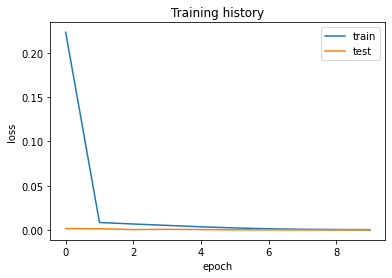

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(16, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
#                         verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_tr, y_tr, epochs=10, batch_size=1, validation_data=(X_te, y_te), verbose=2)

# save the model
model.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a4_dataset/dl_a4_model_q2.h5")

# plot trainiing history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

RMSE for training set: 0.01638577259351742
RMSE for testing  set: 0.0020503458640222733


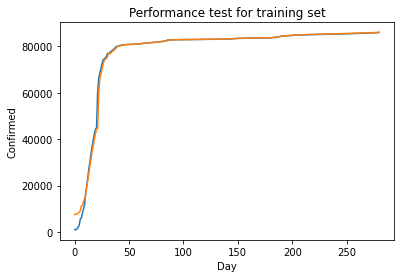

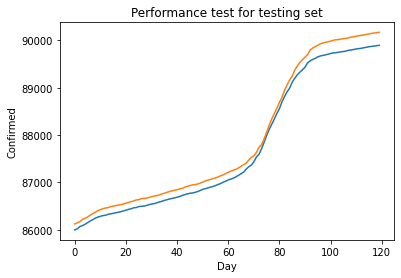

In [ ]:
# load the model and predict the results
model = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a4_dataset/dl_a4_model_q2.h5")
pred_tr = model.predict(X_tr)
pred_te = model.predict(X_te)

# calculate the error
score_tr = np.sqrt(metrics.mean_squared_error(pred_tr,y_tr))
print("RMSE for training set: {}".format(score_tr))
score_te = np.sqrt(metrics.mean_squared_error(pred_te,y_te))
print("RMSE for testing  set: {}".format(score_te))

# restore to original scale
pred_tr_restored = scaler.inverse_transform(pred_tr)
y_tr_restored = scaler.inverse_transform(y_tr)
pred_te_restored = scaler.inverse_transform(pred_te)
y_te_restored = scaler.inverse_transform(y_te)

# plot the results
plt.plot(y_tr_restored)
plt.plot(pred_tr_restored)
plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.title('Performance test for training set')
plt.show()
plt.plot(y_te_restored)
plt.plot(pred_te_restored)
plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.title('Performance test for testing set')
plt.show()
